In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics

import and_gate_pipeline as pipeline
from and_logic_generator import get_not_y
import adversarial_generator as adversarial

# %load_ext autoreload
# %autoreload 2


In [2]:
# Repeatable random generator
seed = 2**12
np.random.seed(seed=seed)


In [3]:
# Step 1: Load data
file_name = 'data_banknote_authentication.csv'
data = np.genfromtxt(file_name, delimiter=',')
data.shape


(1372, 5)

In [4]:
x = data[:, :4]
y = np.array(data[:, 4], dtype=np.int)
print(x.shape)
print(y.shape)
print(x[:5,:])
print(y[:5])
print(len(y[y==1]))


(1372, 4)
(1372,)
[[ 3.6216   8.6661  -2.8073  -0.44699]
 [ 4.5459   8.1674  -2.4586  -1.4621 ]
 [ 3.866   -2.6383   1.9242   0.10645]
 [ 3.4566   9.5228  -4.0112  -3.5944 ]
 [ 0.32924 -4.4552   4.5718  -0.9888 ]]
[0 0 0 0 0]
610


In [5]:
# Step 2: Preprocessing
# zero mean
x_mean = np.mean(x, axis=0)
x = x - x_mean

# scale to [-1, 1] range
x = preprocessing.minmax_scale(
    x, feature_range=(-1, 1), axis=0, copy=True)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2)

print(len(y_train))
print(len(y_test))
print(len(y_test[y_test==1]))


1097
275
127


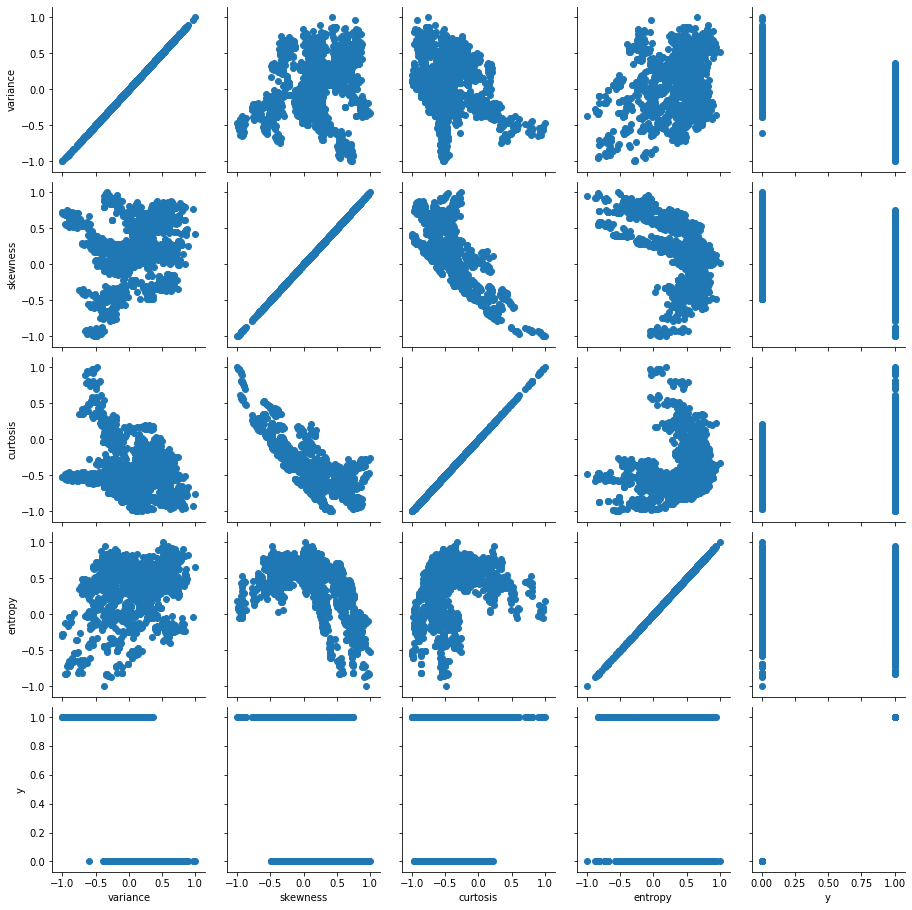

In [6]:
df = pd.DataFrame(data=np.column_stack((x, y)), 
    columns=['variance', 'skewness', 'curtosis', 'entropy', 'y'])
g = sns.PairGrid(df)
g.map(plt.scatter)


In [7]:
# Step 3: Train model
gamma = 'scale'
C = 100

model = svm.SVC(C=C, kernel='rbf', gamma=gamma, random_state=seed)
model.fit(x_train, y_train)
print(model.get_params())
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

gamma = model._gamma
score_train = metrics.accuracy_score(y_train, pred_train)
score_test = metrics.accuracy_score(y_test, pred_test)

print(f'\nWith gamma = {gamma} and C = {C}')
print(f'Accuracy on train set = {score_train*100:.4f}%')
print(f'Accuracy on test set  = {score_test*100:.4f}%')
conf_mat = metrics.confusion_matrix(y_test, pred_test, labels=[0, 1])
print('\nConfusion matrix')
print('Actual classes')
print('     0   1')
for clas, row in zip([0, 1], conf_mat):
    print(clas,row)



{'C': 100, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 4096, 'shrinking': True, 'tol': 0.001, 'verbose': False}

With gamma = 1.0457937498446557 and C = 100
Accuracy on train set = 100.0000%
Accuracy on test set  = 100.0000%

Confusion matrix
Actual classes
     0   1
0 [148   0]
1 [  0 127]


In [8]:
# Step 4: Generate adversarial examples
epsilon = 0.006 # the range of x is [-1, 1]
max_epoch = 2000

ind_train_c0 = np.where(y_train == 0)
x_train_c0 = x_train[ind_train_c0]
mu_train_c0 = np.mean(x_train_c0, axis=0)

ind_train_c1 = np.where(y_train == 1)
x_train_c1 = x_train[ind_train_c1]
mu_train_c1 = np.mean(x_train_c1, axis=0)

print('Negative mean =', mu_train_c0)
print('Positive mean =', mu_train_c1)

x_ae = np.copy(x_test)
pred_ae = np.copy(pred_test)
targets = get_not_y(y_test)

epoch = 1
while np.array_equal(pred_ae, targets) == False and epoch <= max_epoch:
    x_ae = adversarial.moving_mean(
        x=x_ae,
        y=pred_ae,
        targets=targets,
        means={0: mu_train_c0, 1: mu_train_c1},
        epsilon=epsilon,
        verbose=0,
        epoch=epoch)
    pred_ae = model.predict(x_ae)
    epoch += 1

print(f'Completed after {epoch} epoch...')



Negative mean = [ 0.33776593  0.34318811 -0.46723953  0.3493445 ]
Positive mean = [-0.25523004 -0.03713355 -0.36660645  0.32159467]
Completed after 167 epoch...


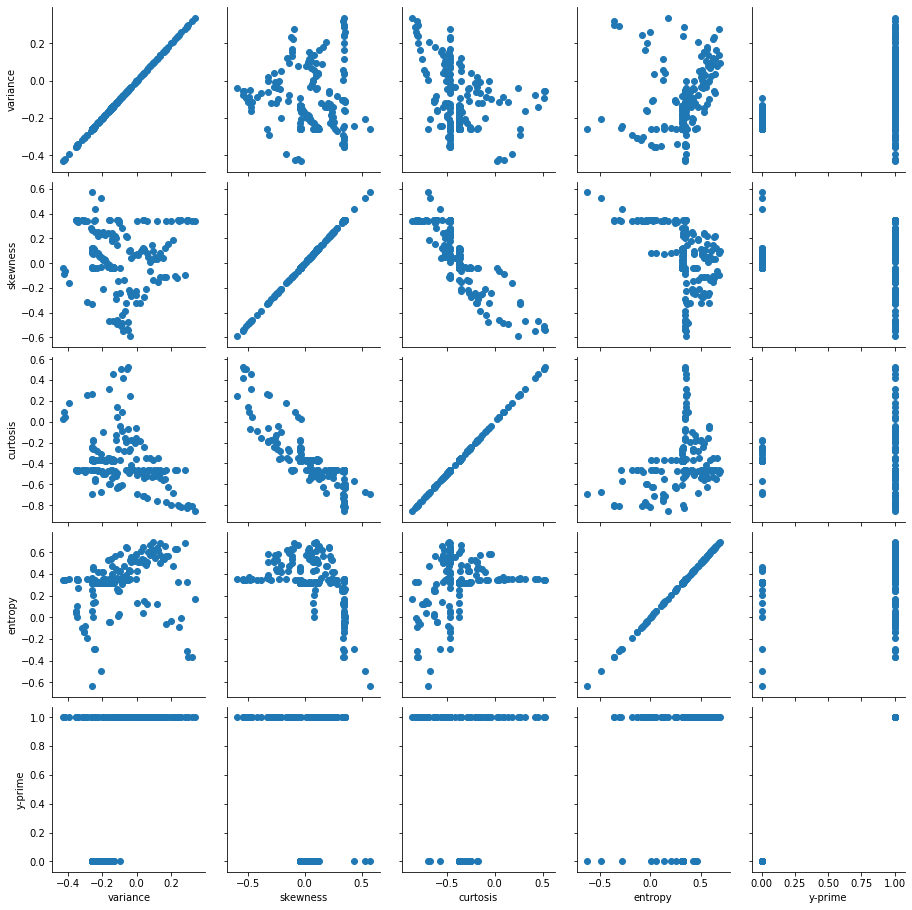

In [9]:
df_ae = pd.DataFrame(data=np.column_stack((x_ae, y_test)), 
    columns=['variance', 'skewness', 'curtosis', 'entropy', 'y-prime'])
g = sns.PairGrid(df_ae)
g.map(plt.scatter)
